In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
sns.set_style('darkgrid')

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

In [2]:
# user-made
import sys
sys.path.append('../scripts')
from tools.preprocess import cut_seq, preprocess_seq

## Preprocess

In [3]:
from synthetic import create_multi

t0 = 96
train = create_multi(4500, t0)
val = create_multi(500, t0)
test = create_multi(1000, t0)

In [4]:
# create training instances(windows)
SRC_LEN, TGT_LEN = t0, 23

In [5]:
# DataLoader
BATCH_SIZE = 64

input = train[:, :-1, :] # (N, SRC_LEN + TGT_LEN, 1)
target = train[:, -23:, :] # (N, TGT_LEN, 1)

train_dset = TensorDataset(torch.Tensor(input), torch.Tensor(target))
train_dloader = DataLoader(train_dset, shuffle=True, batch_size=BATCH_SIZE)
print('Number of training instances:', len(train_dset))

input = val[:, :-1, :] # (N, SRC_LEN + TGT_LEN, 1)
target = val[:, -23:, :] # (N, TGT_LEN, 1)
val_dset = TensorDataset(torch.Tensor(input), torch.Tensor(target))
val_dloader = DataLoader(val_dset, shuffle=False, batch_size=BATCH_SIZE)

Number of training instances: 4500


## Train

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
from model.model import Transformer_fcst

# model
model = Transformer_fcst(fcst_mode='gauss',
                         seq_len=(SRC_LEN, TGT_LEN),
                         embedding_dim=16,
                         nhead=4,
                         num_layers=(2,2),
                         device=device,
                         ts_embed='wavenet',
                         pos_embed='learned').to(device)

In [8]:
from tools.train import EarlyStopping

print(f'BATCH_SIZE:{BATCH_SIZE}')
print(f'SRC_LEN:{SRC_LEN}')
print(f'TGT_LEN:{TGT_LEN}')

# config
criterion = nn.GaussianNLLLoss()
metric_func = nn.L1Loss()

optimizer = torch.optim.Adam(model.parameters() ,lr=1e-3, betas=(0.9, 0.98), weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

PATIENCE = 5
es = EarlyStopping(patience=PATIENCE)
print(f'EarlyStopping patience:{PATIENCE}')

# train
n_epoch = 50
print(f'EPOCH:{n_epoch}')

train_loss_list = torch.zeros(n_epoch, device=device)
val_loss_list = torch.zeros(n_epoch, device=device)
train_metric_list = torch.zeros(n_epoch, device=device)
val_metric_list = torch.zeros(n_epoch, device=device)

print('Started training')

for epoch in range(n_epoch):
    model.train()
    running_train_loss = 0.0
    running_train_mse = 0.0

    for i, data in enumerate(tqdm(train_dloader)):
        input, target = data[0].to(device), data[1].to(device)
        src, tgt = input[:, :SRC_LEN, :], input[:, SRC_LEN:, :]

        optimizer.zero_grad()
        
        mean, var = model(src, tgt)
        loss = criterion(mean, target, var)
        mae = metric_func(mean, target)
        #forecast = model(src, tgt)
        #loss = criterion(forecast, target)

        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        running_train_mse += mae.item()

    # training loss
    train_loss = running_train_loss / len(train_dloader)
    train_loss_list[epoch] = train_loss
    print(f'[Epoch {epoch+1}] Train loss:', f'{train_loss:.4f}', end=' ')

    # metric
    train_mse = running_train_mse / len(train_dloader)
    train_metric_list[epoch] = train_mse
    print('Train MAE:', f'{train_mse}', end=' ')

    scheduler.step()
    

    # validation
    running_val_loss = 0.0
    running_val_mse = 0.0

    with torch.no_grad():
        model.eval()
        
        for i, data in enumerate(val_dloader):
            input, target = data[0].to(device), data[1].to(device)
            src, tgt = input[:, :SRC_LEN, :], input[:, SRC_LEN:, :]

            mean, var = model(src, tgt)
            loss = criterion(mean, target, var)
            mae = metric_func(mean, target)
            #forecast = model(src, tgt)
            #loss = criterion(forecast, target)

            running_val_loss += loss.item()
            running_val_mse += mae.item()
        
        val_loss = running_val_loss / len(val_dloader)
        val_loss_list[epoch] = val_loss
        print('Val loss:', f'{val_loss:.4f}', end=' ')

        val_mse = running_val_mse / len(val_dloader)
        val_metric_list[epoch] = val_mse
        print('Val MAE:', f'{val_mse}')

    # early stopping
    es(val_loss, model, '../_model_pkls')
    if es.early_stop:
        print('Early stopping')
        break
    
# load the best model (early stopping)
model.load_state_dict(torch.load('../_model_pkls/checkpoint.pth'))

BATCH_SIZE:64
SRC_LEN:96
TGT_LEN:23
EarlyStopping patience:5
EPOCH:50
Started training


100%|██████████| 71/71 [00:01<00:00, 36.30it/s]


[Epoch 1] Train loss: 428.5065 Train MAE: 62.53570981092856 Val loss: 129.4235 Val MAE: 52.060988903045654


100%|██████████| 71/71 [00:01<00:00, 38.58it/s]


[Epoch 2] Train loss: 91.1675 Train MAE: 45.59029716169331 Val loss: 51.3510 Val MAE: 37.82898473739624


100%|██████████| 71/71 [00:01<00:00, 38.53it/s]


[Epoch 3] Train loss: 39.8646 Train MAE: 34.133453019907776 Val loss: 25.2504 Val MAE: 29.88712501525879


100%|██████████| 71/71 [00:01<00:00, 38.61it/s]


[Epoch 4] Train loss: 20.2820 Train MAE: 26.421784360643844 Val loss: 10.6884 Val MAE: 18.080643892288208


100%|██████████| 71/71 [00:01<00:00, 38.65it/s]


[Epoch 5] Train loss: 8.3757 Train MAE: 14.804669313027825 Val loss: 4.4464 Val MAE: 9.064014434814453


100%|██████████| 71/71 [00:01<00:00, 38.62it/s]


[Epoch 6] Train loss: 4.5538 Train MAE: 9.433439852486194 Val loss: 3.3393 Val MAE: 7.521819829940796


100%|██████████| 71/71 [00:01<00:00, 38.53it/s]


[Epoch 7] Train loss: 3.4462 Train MAE: 7.686040119386055 Val loss: 2.9224 Val MAE: 6.82239955663681


100%|██████████| 71/71 [00:01<00:00, 38.64it/s]


[Epoch 8] Train loss: 2.8606 Train MAE: 6.379375531639852 Val loss: 2.5635 Val MAE: 5.791916906833649


100%|██████████| 71/71 [00:01<00:00, 38.63it/s]


[Epoch 9] Train loss: 2.5869 Train MAE: 5.68293842799227 Val loss: 2.4252 Val MAE: 4.772820234298706


100%|██████████| 71/71 [00:01<00:00, 38.64it/s]


[Epoch 10] Train loss: 2.4735 Train MAE: 5.385882297032316 Val loss: 2.4802 Val MAE: 5.489818632602692
EarlyStopping counter: 1 out of 5


100%|██████████| 71/71 [00:01<00:00, 38.65it/s]


[Epoch 11] Train loss: 2.3647 Train MAE: 5.099726912001489 Val loss: 2.4067 Val MAE: 5.611531853675842


100%|██████████| 71/71 [00:01<00:00, 38.61it/s]


[Epoch 12] Train loss: 2.1737 Train MAE: 4.404740256322941 Val loss: 2.1830 Val MAE: 4.95665442943573


100%|██████████| 71/71 [00:01<00:00, 38.58it/s]


[Epoch 13] Train loss: 2.0423 Train MAE: 3.920796424570218 Val loss: 2.0403 Val MAE: 4.4465726017951965


100%|██████████| 71/71 [00:01<00:00, 38.63it/s]


[Epoch 14] Train loss: 1.9502 Train MAE: 3.572328181333945 Val loss: 2.0049 Val MAE: 4.436421096324921


100%|██████████| 71/71 [00:01<00:00, 38.51it/s]


[Epoch 15] Train loss: 1.8625 Train MAE: 3.269670654350603 Val loss: 1.9156 Val MAE: 4.009504586458206


100%|██████████| 71/71 [00:01<00:00, 38.64it/s]


[Epoch 16] Train loss: 1.8104 Train MAE: 3.080265350744758 Val loss: 1.8697 Val MAE: 3.8730881214141846


100%|██████████| 71/71 [00:01<00:00, 38.64it/s]


[Epoch 17] Train loss: 1.7864 Train MAE: 3.007109739411045 Val loss: 1.8603 Val MAE: 3.85182124376297


100%|██████████| 71/71 [00:01<00:00, 38.56it/s]


[Epoch 18] Train loss: 1.7515 Train MAE: 2.887530595483914 Val loss: 1.8008 Val MAE: 3.5493568181991577


100%|██████████| 71/71 [00:01<00:00, 38.65it/s]


[Epoch 19] Train loss: 1.7328 Train MAE: 2.8364884215341486 Val loss: 1.7769 Val MAE: 3.4630087316036224


100%|██████████| 71/71 [00:01<00:00, 38.58it/s]


[Epoch 20] Train loss: 1.7069 Train MAE: 2.770206760352766 Val loss: 1.7210 Val MAE: 3.1211366951465607


100%|██████████| 71/71 [00:01<00:00, 38.59it/s]


[Epoch 21] Train loss: 1.6802 Train MAE: 2.688790136659649 Val loss: 1.7802 Val MAE: 3.3400075435638428
EarlyStopping counter: 1 out of 5


100%|██████████| 71/71 [00:01<00:00, 38.58it/s]


[Epoch 22] Train loss: 1.6699 Train MAE: 2.661365740735766 Val loss: 1.7262 Val MAE: 3.1784343123435974
EarlyStopping counter: 2 out of 5


100%|██████████| 71/71 [00:01<00:00, 38.55it/s]


[Epoch 23] Train loss: 1.6584 Train MAE: 2.6180095706187503 Val loss: 1.6440 Val MAE: 2.8561852872371674


100%|██████████| 71/71 [00:01<00:00, 38.54it/s]


[Epoch 24] Train loss: 1.6511 Train MAE: 2.6022530978834126 Val loss: 1.6415 Val MAE: 2.7963331639766693


100%|██████████| 71/71 [00:01<00:00, 38.64it/s]


[Epoch 25] Train loss: 1.6357 Train MAE: 2.5601354887787724 Val loss: 1.8533 Val MAE: 3.569544702768326
EarlyStopping counter: 1 out of 5


100%|██████████| 71/71 [00:01<00:00, 38.54it/s]


[Epoch 26] Train loss: 1.6277 Train MAE: 2.5386909531875395 Val loss: 1.7277 Val MAE: 3.1824626326560974
EarlyStopping counter: 2 out of 5


100%|██████████| 71/71 [00:01<00:00, 38.58it/s]


[Epoch 27] Train loss: 1.6195 Train MAE: 2.514654280434192 Val loss: 1.6963 Val MAE: 3.033296048641205
EarlyStopping counter: 3 out of 5


100%|██████████| 71/71 [00:01<00:00, 38.57it/s]


[Epoch 28] Train loss: 1.6103 Train MAE: 2.4850949368006745 Val loss: 1.6882 Val MAE: 2.9641194343566895
EarlyStopping counter: 4 out of 5


100%|██████████| 71/71 [00:01<00:00, 38.54it/s]


[Epoch 29] Train loss: 1.6129 Train MAE: 2.494971080565117 Val loss: 1.6943 Val MAE: 3.0587011575698853
EarlyStopping counter: 5 out of 5
Early stopping


<All keys matched successfully>

1.6357273
1.8533325


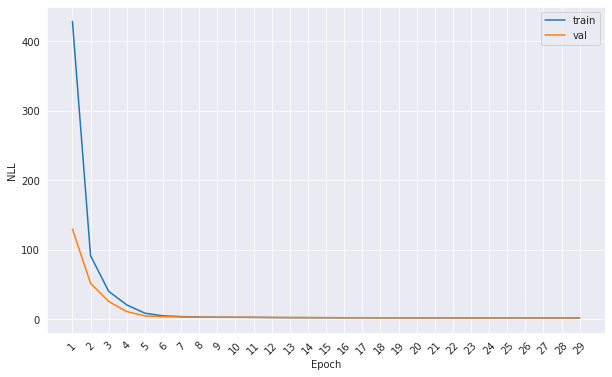

In [10]:
# Plot loss
show = 'loss'

train_value_list = train_loss_list if show == 'loss' else train_metric_list
val_value_list = val_loss_list if show == 'loss' else val_metric_list

train_value_list_detached = train_value_list.cpu().detach().numpy()
val_value_list_detached= val_value_list.cpu().detach().numpy()

train_value_list_detached = train_value_list_detached[train_value_list_detached != 0]
val_value_list_detached = val_value_list_detached[val_value_list_detached != 0]

xticks = np.arange(1, len(train_value_list_detached)+1)
plt.figure(figsize=(10,6))
plt.plot(xticks, train_value_list_detached, label='train')
plt.plot(xticks, val_value_list_detached, label='val')
plt.legend()
plt.xticks(xticks, xticks, rotation='45')
plt.xlabel('Epoch')
plt.ylabel('NLL' if show=='loss' else 'MAE')

print(train_value_list_detached[-PATIENCE])
print(val_value_list_detached[-PATIENCE])

## Loss/MAE History
Order: Train loss / Val loss / Train MAE / Val MAE
- 0721 conv1; fixed
> 2.60 2.94 6.54 8.72 
- 0721 conv4; fixed
> 1.82 1.69 3.15 2.98 
- 0721 conv4; learned
> 1.80 1.65 3.12 2.72
- 0721 wv4; fixed
> 1.67 1.39 2.67 1.94
- 0721 wv4; learned
> 1.57 1.29 2.42 1.74
- 0721 wv5; fixed
> 1.51 1.54 2.24 2.73


In [22]:
# save the model
file_name = 'syn_conv4_fixed_0721.pth'
torch.save(model.state_dict(), f'../_model_pkls/{file_name}')

## Eval

In [36]:
# load model
load = True
if load:
    file_name = 'syn_wv4_learned_0721.pth'
    model.load_state_dict(torch.load(f'../_model_pkls/{file_name}'))

In [37]:
from tools.infer import plot_eval_gauss

# get a single batch from val_dloader
sample = next(iter(train_dloader))

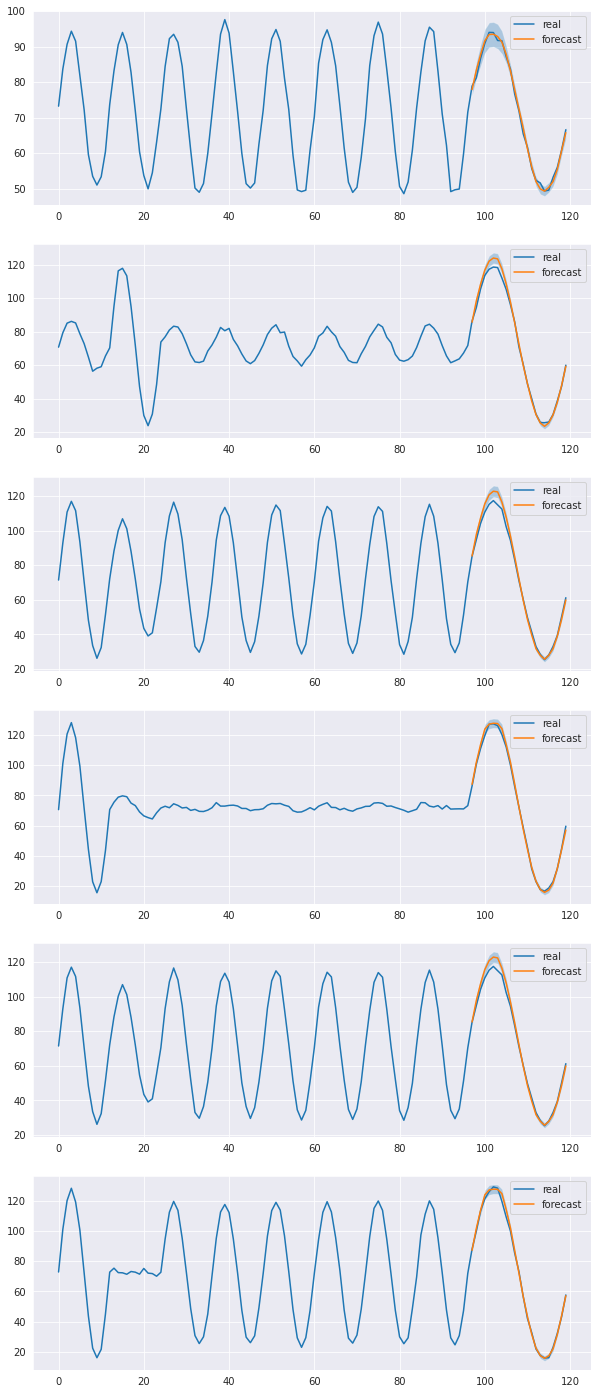

In [39]:
# short-term (rolling-minute prediction); gauss

## forward
model.eval()

input, target = sample[0].to(device), sample[1].to(device)
src, tgt = input[:, :SRC_LEN, :], input[:, SRC_LEN:, :]
mean, var = model(src, tgt)

## to numpy array
input = input.cpu().detach().numpy()
target = target.cpu().detach().numpy()
mean = mean.cpu().detach().numpy()
var = var.cpu().detach().numpy()
sample_nums = np.random.choice(BATCH_SIZE, 6)

## plot
fig, axs = plt.subplots(6,1, figsize=(10,25))

for i, sample_num in enumerate(sample_nums):
    input_ = input[sample_num].squeeze(-1)
    target_ = target[sample_num].squeeze(-1)
    mean_ = mean[sample_num].squeeze(-1)
    var_ = var[sample_num].squeeze(-1)

    plot_eval_gauss(input_, target_, mean_, var_, axs[i], cut_head=0, quantile=0.5)